In [77]:
import numpy as np
import scipy.special as sp

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import copy 
import time
import random

import torch
import torch.nn as nn
import torch.optim as optim
import collections

# Necessary imports

import numpy as np
import matplotlib.pyplot as plt
from torch.nn import Linear
 
from qiskit import QuantumCircuit
#from qiskit.utils import algorithm_globals
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZFeatureMap
from qiskit_machine_learning.neural_networks import SamplerQNN
from qiskit_machine_learning.connectors import TorchConnector
from sklearn.metrics import accuracy_score
import pylatexenc

from qiskit.circuit.library import ZZFeatureMap, EfficientSU2

import pandas as pd

torch.backends.cudnn.benchmark = True


In [78]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

directory = 'Experiments/'
experiment_id = '2Qubits/'

num_qubits = 2
num_layers = 1

features = ["SEED1", "TEAM1_ID", "DUNKS FG%1","SEED2", "TEAM2_ID", "DUNKS FG%2", "CURRENT ROUND"]
target = "WINNER"

feature_map_experiment = ZFeatureMap
#feature_map_experiment = ZZFeatureMap

ansatz_experiment = RealAmplitudes
#ansatz_experiment = EfficientSU2


cpu


QNN Training Parameters: 4
QNN Input Parameters: 2
QNN Circuit Depth: 2


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_4035/3992426414.py:10: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = SamplerQNN(


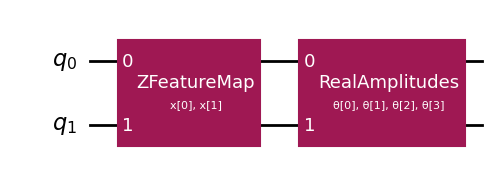

In [79]:
def create_qnn():
    qc = QuantumCircuit(num_qubits)
    feature_map = feature_map_experiment(num_qubits)
    ansatz = ansatz_experiment(num_qubits=num_qubits, reps=num_layers)

    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
    )
    
    return qnn

qnn = create_qnn()

print("QNN Training Parameters:", qnn.num_weights) 
print("QNN Input Parameters:", qnn.num_inputs)
print("QNN Circuit Depth:", qnn.circuit.depth())

qnn.circuit.draw('mpl')

In [80]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.qnn = nn.Sequential(nn.LazyLinear(len(features)),
            nn.LazyLinear(qnn.num_inputs),
            nn.Tanh(),
            TorchConnector(qnn),
            nn.LazyLinear(1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.qnn(x)
        return x

In [81]:
from torch.optim.lr_scheduler import StepLR  

net = Model().to(device)
optimizer = optim.AdamW(net.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=200, gamma=0.01)
criterion = nn.BCELoss()
batch_size = 32
num_epochs = 1500

net.to(device)
net.train()

Model(
  (qnn): Sequential(
    (0): LazyLinear(in_features=0, out_features=7, bias=True)
    (1): LazyLinear(in_features=0, out_features=2, bias=True)
    (2): Tanh()
    (3): TorchConnector()
    (4): LazyLinear(in_features=0, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [82]:
# Load data
import pandas as pd

df = pd.read_csv("Games.csv")

df['TEAM1_ID'] = df['TEAM1_ID'].fillna(-1)
df['TEAM2_ID'] = df['TEAM2_ID'].fillna(-1)



df = df.fillna(0)

team_id_name_dict = {}

for _, row in df.iterrows():
    key1 = row['TEAM1_ID']
    value1 = row['TEAM1']

    key2 = row['TEAM2_ID']
    value2 =  row['TEAM2']

    team_id_name_dict[key1] = value1
    team_id_name_dict[key2] = value2

test_years = [2013 ,2018, 2025]
              
test_df = df[df["YEAR"].isin(test_years)]
test_df = test_df.drop_duplicates(subset=['YEAR', 'TEAM1', 'CURRENT ROUND'])
test_df = test_df.dropna(subset=['WINNER'])

train_val_df = df[~df["YEAR"].isin(test_years)]

from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(train_val_df, test_size=0.2, random_state=42)


In [83]:

print(test_df['YEAR'].unique())
print(train_df['YEAR'].unique())


[2025 2018 2013]
[2021 2017 2014 2019 2009 2016 2015 2010 2011 2008 2012 2024 2022 2023]


In [84]:
from torch.utils.data import TensorDataset, DataLoader

def to_tensor(df):
    X = torch.tensor(df[features].values, dtype=torch.float32)
    y = torch.tensor(df[target].values, dtype=torch.float32).unsqueeze(1)
    return TensorDataset(X, y)

In [85]:
train_dataset = to_tensor(train_df)
val_dataset = to_tensor(val_df)


In [86]:
from torch.utils.data import TensorDataset, DataLoader

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [87]:
def plot_loss(train, val):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.legend()
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.savefig(directory + experiment_id+  'loss.png')
    plt.show()
    
def plot_accuracy(train, val):
    plt.plot(train, label='Train')
    plt.plot(val, label='Validation')
    plt.xlim(0, num_epochs)
    plt.grid()
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.savefig(directory + experiment_id+ 'accuracy.png')
    plt.show()
 

In [12]:
def calc_val_accuracy(loader):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            predicted = (outputs > 0.5).float()

            total += labels.size(0)

            correct += (predicted == labels).sum().item()

    return correct / total

def calc_val_loss(loader):
    val_loss = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    return val_loss / len(loader)

def calc_train_accuracy(X, y):
    correct = 0
    total = 0
    with torch.no_grad():
        outputs = net(X)
        predicted = (outputs > 0.5).float()

        total += y.size(0)

        correct += (predicted == y).sum().item()
    return correct / total

Epoch [1500/1500]

Train Loss: 0.5508
Validation Loss: 0.6103

Train Accuracy: 0.7273
Validation Accuracy: 0.6780 



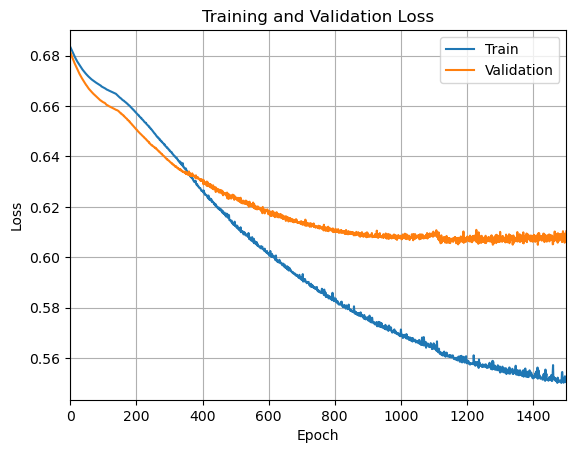

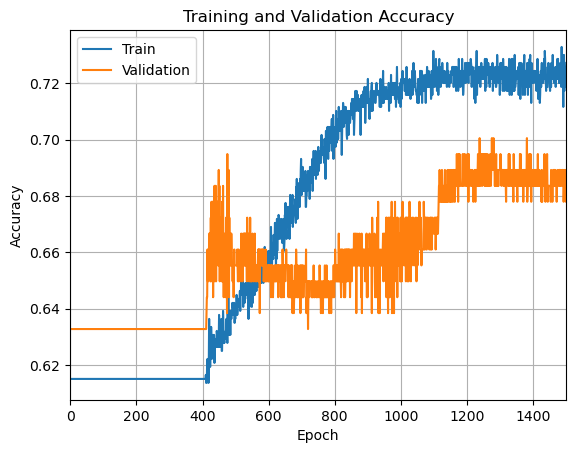

Model saved at epoch 1285 with loss 0.6069
Model saved at epoch 1282 with accuracy 0.6894


In [13]:
# Initialize lists to store losses and accuracies
losses = []
val_losses = []

best_loss = float('inf')
best_accuracy = 0.0

loss_epoch = 0
accuracy_epoch = 0

train_accuracys = []
val_accuracys = []

# Training loop
for epoch in range(num_epochs+1):
    
    epoch_loss = 0.0
    epoch_accuracy = 0.0

    for X_batch, y_batch in train_loader:
    
        # Move data to device
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass
        preds = net(X_batch)

        if preds.shape != y_batch.shape:
            y_batch = y_batch.view(preds.shape)
      
        # Calculate loss
        loss = criterion(preds, y_batch.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_accuracy += calc_train_accuracy(X_batch, y_batch)
        epoch_loss += loss.item()
  
    val_loss = calc_val_loss(val_loader)
    val_accuracy = calc_val_accuracy(val_loader)

    losses.append(epoch_loss / len(train_loader))
    train_accuracys.append(epoch_accuracy / len(train_loader))

    val_accuracys.append(val_accuracy)
    val_losses.append(val_loss)
        
    clear_output(wait=True)
    print(f"Epoch [{epoch}/{num_epochs}]\n")
    print(f"Train Loss: {epoch_loss / len(train_loader):.4f}")
    print(f"Validation Loss: {val_loss:.4f}\n")
    print(f"Train Accuracy: {epoch_accuracy / len(train_loader):.4f}")
    print(f"Validation Accuracy: {val_accuracy:.4f} \n")

    
    if epoch > 100:

        running_loss = np.mean(val_losses[-50:])
        running_accuracy = np.mean(val_accuracys[-50:])

        if running_loss < best_loss:
            best_loss = running_loss
            loss_epoch = epoch
            torch.save(net.state_dict(), directory + experiment_id + 'best_lost_model.pth')
            
        if running_accuracy > best_accuracy:
            best_accuracy = running_accuracy
            accuracy_epoch = epoch
            torch.save(net.state_dict(), directory + experiment_id + 'best_accuracy_model.pth')
        
    if epoch % 50 == 0:
        plot_loss(losses, val_losses)
        plot_accuracy(train_accuracys, val_accuracys)
        print(f"Model saved at epoch {loss_epoch} with loss {best_loss:.4f}")
        print(f"Model saved at epoch {accuracy_epoch} with accuracy {best_accuracy:.4f}")


torch.save(net.state_dict(), directory + experiment_id + 'final_model.pth')
        

In [88]:
# Load the best model
best_model = Model().to(device)
best_model.load_state_dict(torch.load(directory + experiment_id+ 'best_accuracy_model.pth', map_location=torch.device('cpu')))
best_model.eval()

test_dict = {}



team1_features = ["SEED1",  "TEAM1_ID", "DUNKS FG%1"]
team2_features = ["SEED2", "TEAM2_ID", "DUNKS FG%2"]

for year in test_years:
    print(f"Testing year: {year}")
    test_year_df = test_df[test_df["YEAR"] == year]
    test_year_df = test_year_df[test_year_df["CURRENT ROUND"] == 64]

    team1_X = torch.tensor(test_year_df[team1_features].values, dtype=torch.float32)
    team2_X = torch.tensor(test_year_df[team2_features].values, dtype=torch.float32)

    y = torch.tensor(test_year_df[target].values, dtype=torch.float32).unsqueeze(1)

    test_dict[year] = {}
    test_dict[year]['team1'] = team1_X
    test_dict[year]['team2'] = team2_X
    test_dict[year]['y'] = y

round_winner_dict = {}

for year in [2013, 2018]:
    
    test_year_df = test_df[test_df["YEAR"] == year]

    round_winner_dict[year] = {64:[], 32:[], 16:[], 8:[], 4:[], 2:[]}
    
    for _, row in test_year_df.iterrows():

        key = row['CURRENT ROUND']

        y = row['WINNER']
        value = row['TEAM1_ID']
        if y == 1:
            value = row['TEAM2_ID']

        round_winner_dict[year][key].append(value)
 




Testing year: 2013
Testing year: 2018
Testing year: 2025


/var/folders/ks/75nc1bbj5y927lr6v6qstz540000gn/T/ipykernel_4035/2396162330.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load(director

In [89]:

round_winner_dict[2025] = {64:[41, 27, 21, 24, 0, 140, 20, 25, 31, 55, 3, 123, 30, 15, 2, 13, 36, 23, 5, 64, 16, 22, 12, 11, 8, 29, 103, 19, 9, 28, 7, 18],
                           32:[27, 55, 2, 13, 0, 20, 24, 31, 8, 16, 29, 23, 11, 12, 7, 19],
                           16:[23, 8, 16, 13, 7, 31, 0, 24],
                           8:[8, 16, 24, 0],
                           4:[8, 24],
                           2:[8]}

In [90]:
def print_team(team):
    return team_id_name_dict[team[1].item()]

def round_predict(model, temp ,year, points =0, higher_seed =0, total_chances = 63, printout=True):
    results = {}
    team_nums = int(temp['team1'].shape[0]*2)

    team1 = temp['team1']
    team2 = temp['team2']

    combined = torch.cat((team1, team2), dim=1)
    round = torch.tensor([team_nums], dtype=torch.float32).unsqueeze(1).repeat(combined.shape[0], 1)
    combined = torch.cat((combined, round), dim=1)
    combined = combined.to(device)

    current_round_points = 0
    
    results = {'team1': [], 'team2': []}
    for i in range(0,combined.shape[0], 2):
        game1 = combined[i]
        game2 = combined[i+1]

        outcome1 = model(game1)
        outcome2 = model(game2)

        winner1 =0
        winner2 = 0

        if outcome1<.5:
            winner1 = team1[i]
            if team1[i][0]<team2[i][0]:
                higher_seed += 1
        else:
            winner1 = team2[i]
            if team2[i][0]<team1[i][0]:
                higher_seed += 1
            
        if team2[i][0]==team1[i][0]:
            total_chances = total_chances -1

        if outcome2<.5:
            winner2 = team1[i+1]
            if team1[i+1][0]<team2[i+1][0]:
                higher_seed += 1
            
        else:
            winner2 = team2[i+1]
            if team2[i+1][0]<team1[i+1][0]:
                higher_seed += 1

        if team1[i+1][0] ==  team2[i+1][0]:
            total_chances = total_chances -1 

        
        results['team1'].append(winner1)
        results['team2'].append(winner2)

        current_round_points = cbs_points(int(winner1[1].item()), team_nums, year)

        if printout:
            print( print_team(team1[i]), "vs", print_team(team2[i]), "Winner:", print_team(winner1))
            print("     Points: ", current_round_points)
        points += current_round_points

        current_round_points = cbs_points(int(winner2[1].item()), team_nums, year)
        
        if printout:
            print( print_team(team1[i+1]), "vs", print_team(team2[i+1]), "Winner:", print_team(winner2))
            print("     Points: ", current_round_points)
        points += current_round_points
            

    results['team1'] = torch.stack(results['team1'])
    results['team2'] = torch.stack(results['team2'])
    if printout:
        print("Higher seed: ", higher_seed, total_chances)
        print("Total Points: ", points)
    return results, points, higher_seed, total_chances

def championship(best_model,temp, year, points = 0, higher_seed =0, total_chances = 63): 
    
    team1 = temp['team1']
    team2 = temp['team2']

    round_points = 0

    combined = torch.cat((team1, team2), dim=1)
    round = torch.tensor([2], dtype=torch.float32).unsqueeze(1)
    combined = torch.cat((combined, round), dim=1)
    combined = combined.to(device)

    outcome = best_model(combined)

    winner = None
    if outcome < .5:
        winner = team1
        print(team1)
        if team1[0][0]<team2[0][0]:
                higher_seed += 1
    else:
        winner = team2
        print(team2)
        if team2[0][0]<team1[0][0]:
                higher_seed += 1

    if team2[0][0]==team1[0][0]:
        total_chances = total_chances- 1
        
    round_points += cbs_points(winner[0][1].item(), 2, year)

    print("Championship")
    print(team_id_name_dict[team1[0][1].item()], " vs ", team_id_name_dict[team2[0][1].item()])

    print("     Winner: ", team_id_name_dict[winner[0][1].item()])
    print("     Points: ", round_points)
    points += round_points
    print(" Higher seed chosen, when given the chance: ", higher_seed/ total_chances)
    print("Total Points: ", points)

def tournament_predict(best_model, temp, year):

    temp = temp[year]
    round1, points1, higer_seed1, total_chances1 = round_predict(best_model, temp, year, printout = False)
    round2, points2, higer_seed1, total_chances1 = round_predict(best_model, round1, year,  points = points1, higher_seed =higer_seed1, total_chances= total_chances1,printout=False)
    round3, points3 ,higer_seed1, total_chances1= round_predict(best_model, round2, year, points = points2, higher_seed = higer_seed1,total_chances= total_chances1, printout= False)
    print("Elite 8")
    round4, points4, higer_seed1 , total_chances1= round_predict(best_model, round3, year,higher_seed = higer_seed1, total_chances= total_chances1,points= points3)
    print("\nFinal Four")
    round5, points5, higer_seed1, total_chances1 = round_predict(best_model,round4, year, higher_seed = higer_seed1,total_chances= total_chances1,points= points4)
    print("\n")
    championship(best_model, round5, year,higher_seed = higer_seed1, total_chances= total_chances1,points= points5)

def cbs_points(winner, round, year):
    round_winners = round_winner_dict[year][round]
    if winner in round_winners:
        return 32 / (round//2)
    else:
        return 0




In [91]:
year = 2013
print("Year: ", year, '\n')
temp= test_dict
tournament_predict(best_model, temp, year)

Year:  2013 

Elite 8
Louisville vs Memphis Winner: Louisville
     Points:  8.0
Gonzaga vs Arizona Winner: Gonzaga
     Points:  0
Kansas vs UCLA Winner: Kansas
     Points:  0
Indiana vs Butler Winner: Indiana
     Points:  0
Higher seed:  48 63
Total Points:  42.0

Final Four
Louisville vs Gonzaga Winner: Louisville
     Points:  16.0
Kansas vs Indiana Winner: Kansas
     Points:  0
Higher seed:  48 61
Total Points:  58.0


tensor([[ 1.0000,  1.0000, 92.5000]])
Championship
Louisville  vs  Kansas
     Winner:  Louisville
     Points:  32.0
 Higher seed chosen, when given the chance:  0.8
Total Points:  90.0


In [92]:
year = 2018
print("Year: ", year, '\n')
temp= test_dict
tournament_predict(best_model, temp, year)

Year:  2018 

Elite 8
Virginia vs Miami FL Winner: Virginia
     Points:  0
Xavier vs Houston Winner: Xavier
     Points:  0
Villanova vs Florida Winner: Villanova
     Points:  8.0
Kansas vs TCU Winner: Kansas
     Points:  8.0
Higher seed:  48 63
Total Points:  61.0

Final Four
Virginia vs Xavier Winner: Virginia
     Points:  0
Villanova vs Kansas Winner: Villanova
     Points:  16.0
Higher seed:  48 61
Total Points:  77.0


tensor([[ 1.0000, 48.0000, 94.6000]])
Championship
Virginia  vs  Villanova
     Winner:  Virginia
     Points:  0
 Higher seed chosen, when given the chance:  0.8
Total Points:  77.0


In [93]:
year = 2025
print("Year: ", year, '\n')
temp= test_dict
tournament_predict(best_model, temp, year)

Year:  2025 

Elite 8
Auburn vs Mississippi Winner: Auburn
     Points:  8.0
Florida vs Missouri Winner: Florida
     Points:  8.0
Duke vs BYU Winner: Duke
     Points:  8.0
Houston vs Illinois Winner: Houston
     Points:  8.0
Higher seed:  48 63
Total Points:  87.0

Final Four
Auburn vs Florida Winner: Auburn
     Points:  0
Duke vs Houston Winner: Duke
     Points:  0
Higher seed:  48 61
Total Points:  87.0


tensor([[ 1.0000,  0.0000, 86.1000]])
Championship
Auburn  vs  Duke
     Winner:  Auburn
     Points:  0
 Higher seed chosen, when given the chance:  0.8
Total Points:  87.0
